There are lots of different types of DMD now. Among them are 'streaming', or online DMD algorithms. These methods are very attractive because of their low memory usage, and their ability to operate incrementally on data streams.

First, we need to do some setup and get some data. We'll use the bus station dataset this time.

In [1]:
import os
import sys
import imageio
import numpy as np
import skimage
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt

# from pydmd import MrDMD, DMD

In [2]:
DATASET = os.path.join(os.curdir, "../data")
os.listdir(DATASET)

['peopleInShade',
 'backdoor',
 'busStation',
 'copyMachine',
 'PETS2006',
 'skating',
 'pedestrians',
 'office',
 'sofa',
 'cubicle']

In [3]:
def load_images(path, shape=None):
    files = os.listdir(path)
    data = None

    for f in files:
        fp = os.path.join(path, f)
        num = int(f[2:8])
        im = io.imread(fp, as_gray=True)
        if shape is not None:
            im = transform.resize(im, shape)
        if data is None:
            data = np.zeros((im.size, len(files)))
        elif num < data.shape[1]:
            data[:,num] = im.flatten()
            
    return data

In [4]:
# Investigate a single video: Pedestrians
# Was having memory problems, so controlled the image size with shape
# shape = (60,90);
shape = (120,180)
dt = 1  # Assumption
BUSSTATION = os.path.join(DATASET,'busStation/input')
ims = load_images(BUSSTATION, shape)
N = ims.shape[1]

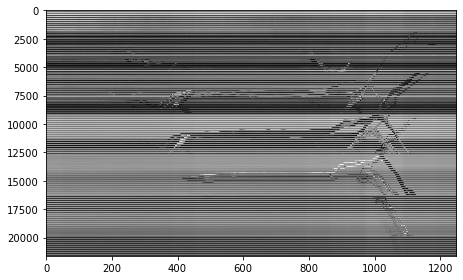

In [5]:
# This is what the data matrix looks like. Note that its very easy to pick out the pixels where 
# pedestrians are walking. However, they are pretty scattered and non-local. It would be interesting
# to try the tensor-based decomposition instead.

def plot_data(data):
    fig = io.imshow(np.real(data))
    fig.axes.set_aspect('auto')
    
def plot_image(im, shape=shape):
    io.imshow(im.clip(min=0,max=1).reshape(shape), vmin=0, vmax=1, cmap="gray")
    
plot_data(ims)


# Dynamic mode decomposition for large and streaming datasets - Hemati et al

The original! Abbrieviated as SDMD. 

There are 5 steps that this algorithm performs every iteration.
1. For each pair of data points, compute the residuals using the current bases. Use Gram-Schidt to ensure orthogonality
2. If one (or both) of the residuals are larger than the threshold, add the normalised residuals to the corresponding basis while zero padding the other matrices.
3. If either basis becomes too large, compute the leading eigvecs and diagonalise?
4. Update A, Gx, and Gy using the projected data.
5. Compute the DMD modes / eigenvalues



In [6]:
class SDMD:
    def __init__(self, max_rank=None, ngram=5, epsilon=np.finfo(float).eps):
        self.Qx = None
        self.Qy = None
        self.Gx = None
        self.Gy = None
        self.A = None
        self.max_rank = max_rank   # Maximum rank that our bases can have
        self.ngram = ngram         # Number of times to reapply Gram-Schmidt
        self.precision = epsilon
    
    def stream(self,x,y):
        normx = np.linalg.norm(x)
        normy = np.linalg.norm(y)
            
        # The data stream might contain a blank input
        if normx < self.precision or normy < self.precision:
            return 
        
        # Initialise data as columns matrices
        x = np.matrix(x)
        y = np.matrix(y)
        if x.shape[0] == 1: x = x.T;
        if y.shape[0] == 1: y = y.T;
            
        # Initialise bases on first iteration
        if self.Qx is None or self.Qy is None:
            self.Qx = x / normx
            self.Qy = y / normy
            self.Gx = np.matrix(normx**2)
            self.Gy = np.matrix(normy**2)
            self.A = np.matrix(normx * normy)
            return
        
        # Gram-Schmidt reorthonormalization
        xtilde = np.zeros((self.Qx.shape[1],1))
        ytilde = np.zeros((self.Qy.shape[1],1))
        ex = x
        ey = y
        for _ in range(self.ngram):
            dx = self.Qx.T @ ex
            dy = self.Qy.T @ ey
            xtilde = xtilde + dx
            ytilde = ytilde + dy
            ex = ex - self.Qx @ dx
            ey = ey - self.Qy @ dy
            
        # If the residuals are not described by the current bases, we need to update the bases 
        # to accomodate the new data. We then also need to zero pad the G and A matrices 
        if np.linalg.norm(ex) / normx > self.precision:
            self.Qx = np.concatenate((self.Qx, ex), axis=1)
            self.Gx = np.pad(self.Gx, ((0,1),(0,1)))
            self.A = np.pad(self.A, ((0,0),(0,1)))
            
        if np.linalg.norm(ey) / normy > self.precision:
            self.Qy = np.concatenate((self.Qy, ey), axis=1)
            self.Gy = np.pad(self.Gy, ((0,1),(0,1)))
            self.A = np.pad(self.A, ((0,1),(0,0)))
            
        # If the rank is too high, then we need to compress the matrices again using POD
        if self.max_rank is not None:
            if self.Qx.shape[1] > self.max_rank:
                eigval, eigvec  = np.linalg.eig(self.Gx)
                idxs = np.argsort(-eigval)
                qx = eigvec[:,idxs[:self.max_rank]]
                self.Qx = self.Qx @ qx
                self.A  = self.A @ qx
                self.Gx = np.diag(eigval[idxs[:self.max_rank]]);
            if self.Qy.shape[1] > self.max_rank:
                eigval, eigvec = np.linalg.eig(self.Gy)
                idxs = np.argsort(-eigval)
                qy = eigvec[:,idxs[:self.max_rank]]
                self.Qy = (self.Qy @ qy);
                self.A  = (qy.T @ self.A);
                self.Gy = np.diag(eigval[idxs[:self.max_rank]]);
        
        
        # Update matrices using the outer products of the data pair
        xtilde = (self.Qx.T @ x)
        ytilde = (self.Qy.T @ y)

        # update A, Gx, Gy
        self.Gx = self.Gx + xtilde @ xtilde.T;
        self.Gy = self.Gy + ytilde @ ytilde.T;
        self.A = self.A + ytilde @ xtilde.T;
        
    def compute_modes(self):
#         print(self.Qx, self.Qy, self.A, self.Gx)
        if any(x is None for x in (self.Qx, self.Qy, self.A, self.Gx)):
            return None, None
        Ktilde = self.Qx.T @ self.Qy @ self.A @ np.linalg.pinv(self.Gx) # @ self.A @ np.array(np.linalg.pinv(self.Gx))
#         print(Ktilde.shape)
        eigvals, eigvecs  = np.linalg.eig(Ktilde)
        eigvals = np.matrix(np.diag(eigvals)).T
        modes = self.Qx @ np.vstack(eigvecs)
        return modes, eigvals

In [7]:
sdmd = SDMD(max_rank=3)

i = 300


301

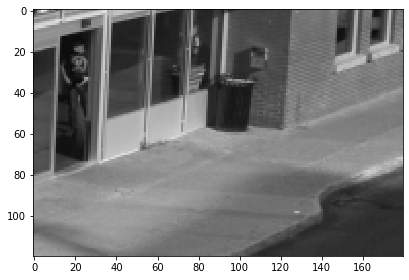

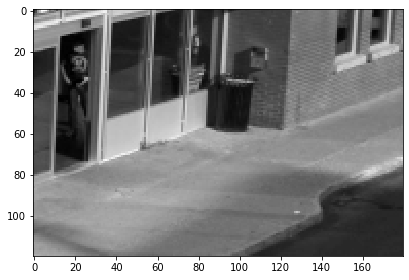

In [8]:
i += 1
if i > 0 and i < N:
    x, y = ims[:,i-1], ims[:,i]
    sdmd.stream(x,y)
    modes, eigvals = sdmd.compute_modes()
    if modes is not None:
        background = modes[:,0]
        background = np.interp(background.real, (background.min(), (background).max()), (0,1))
        plot_image(x)
        plt.figure()
        plot_image(background)

i

In [9]:
a = np.random.randn(4)


In [263]:
class STDMD:
    def __init__(self, max_rank=None, ngram=5, epsilon=np.finfo(float).eps):
        self.Qx = None
        self.Qy = None
        self.Gx = None
        self.Gy = None
        self.A = None
        
        self.Qz = None
        self.Gz = None
        self.max_rank = max_rank   # Maximum rank that our bases can have
        self.ngram = ngram         # Number of times to reapply Gram-Schmidt
        self.precision = epsilon
    
    def stream(self, x, y):
        n = x.ravel().shape[0]
        x = np.asmatrix(x).reshape((n,1))
        y = np.asmatrix(y).reshape((n,1))
        
        z = np.concatenate((x,y), axis=0)
        normz = np.linalg.norm(z)
        
        # Initialise bases on first iteration
        if self.Qz is None or self.Gz is None:
            self.Qz = z/normz
            self.Gz = np.matrix(normz**2)
            return
        
        # Gram-Schmidt reorthonormalisation
        ztilde = np.zeros((self.Qz.shape[1],1))
        ez = z
        for _ in range(self.ngram):
            dz = self.Qz.T @ ez
            ztilde += dz
            ez -= self.Qz @ dz
            
        # Update basis if necessary
        if np.linalg.norm(ez) / normz > self.precision:
            self.Qz = np.concatenate((self.Qz, ez / normz), axis=1)
            self.Gz = np.pad(self.Gz, ((0,1), (0,1)))
        
        ztilde = self.Qz.T @ z
        self.Gz += (ztilde @ ztilde.T)
        
        
        if self.max_rank is not None:
            if self.Qz.shape[1] > self.max_rank:
                eigval, eigvec  = np.linalg.eig(self.Gz)
                idxs = np.argsort(-eigval)
                qz = eigvec[:,idxs[:self.max_rank]]
                self.Qz = self.Qz @ qz
                self.Gz = np.diag(eigval[idxs[:self.max_rank]])
            
    def compute_modes(self):
        n = self.Qz.shape[0] // 2;
        Qx, Rx = np.linalg.qr(self.Qz[:n,:])
        if self.max_rank:
            Qx = Qx[:,:self.max_rank]
            Rx = Rx[:self.max_rank, :]
            
        Gx = Rx @ self.Gz @ Rx.T
        A = Qx.T @ self.Qz[n:, :] @ self.Gz @ self.Qz[:n,:].T @ Qx  # TODO: check that these are all good, I found a type in the sample code
        
        Ktilde = A @ np.linalg.pinv(Gx);
        eigvals, eigvecs = np.linalg.eig(Ktilde);
        modes = Qx @ eigvecs;
        idxs = np.argsort(-eigvals)
        return modes[:,idxs], eigvals[idxs]

In [363]:

stdmd = STDMD(max_rank=10)

i = 200


227

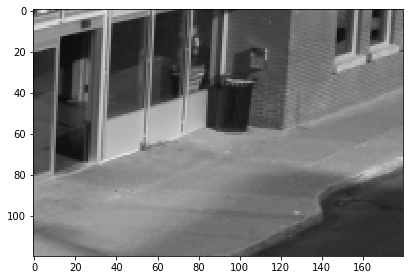

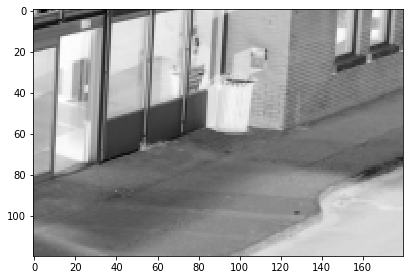

In [390]:
i += 1
if i > 0 and i < N:
    x, y = ims[:,i-1], ims[:,i]
    stdmd.stream(x,y)
    modes, eigvals = stdmd.compute_modes()
    if modes is not None:
        background = modes[:,0]
        background = np.interp(background.real, (background.min(), (background).max()), (0,1))
        plot_image(x)
        plt.figure()
        plot_image(background)

i

In [22]:
a = np.random.randn(5,5)
np.linalg.eig(a)

(array([-0.46960205+1.60576019j, -0.46960205-1.60576019j,
        -0.06952604+0.j        ,  0.50123659+0.27119034j,
         0.50123659-0.27119034j]),
 array([[-0.16893424-0.27349692j, -0.16893424+0.27349692j,
          0.05410359+0.j        ,  0.23012493-0.18674278j,
          0.23012493+0.18674278j],
        [-0.32525036+0.27030711j, -0.32525036-0.27030711j,
         -0.2349845 +0.j        ,  0.11034391-0.24596416j,
          0.11034391+0.24596416j],
        [-0.46526744-0.12755159j, -0.46526744+0.12755159j,
          0.7356099 +0.j        ,  0.37331378+0.14686875j,
          0.37331378-0.14686875j],
        [ 0.55426153+0.j        ,  0.55426153-0.j        ,
          0.49097936+0.j        ,  0.79935349+0.j        ,
          0.79935349-0.j        ],
        [-0.27085753-0.32325545j, -0.27085753+0.32325545j,
          0.39959032+0.j        ,  0.15000948-0.13074038j,
          0.15000948+0.13074038j]]))